<a href="https://colab.research.google.com/github/Satrio-Arif/Discoffery/blob/ML/EfficientNet_Lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
!pip install split-folders -q
import splitfolders
import os
import tensorflow as tf
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import numpy as np
import pathlib
import seaborn as sns
from google.colab import files
from keras.preprocessing import image
from keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
print(tf.__version__)

2.8.0


# Importing Dataset

In [ ]:
# Download dataset

# Toraja
!wget -q "https://drive.google.com/uc?export=download&id=1_8uS-fTimBbYyJmC3N_I30u5NabAc9Oc" -O toraja.zip
# Dampit
!wget -q "https://drive.google.com/uc?export=download&id=1RC9EI5Jb4ViIIdyKenKy1_22JVEOzEgo" -O dampit.zip
# Aceh Gayo
!wget -q "https://drive.google.com/uc?export=download&id=13bb9ABabkKbvEzlrpDxQ2e-6V4kZX0on" -O acehgayo.zip

# Extracting & Splitting Dataset

In [ ]:
# Make directory dirty_data
!mkdir dirty_data

In [ ]:
# Unzipping file
!unzip -j -q toraja.zip -d "dirty_data/toraja"
!unzip -j -q dampit.zip -d "dirty_data/dampit"
!unzip -j -q acehgayo.zip -d "dirty_data/acehgayo"

In [ ]:
# Splitting data into ratio 80% for training, 10% for validation, and 10% for testing
splitfolders.ratio("dirty_data", output="dataset", seed=42, ratio=(.8, .1, 0.1), group_prefix=None)

Copying files: 1500 files [00:00, 4184.99 files/s]


In [ ]:
# Removing unused folders
!rm -rf dirty_data

In [ ]:
base_dir = 'dataset'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Directory with training acehgayo, dampit, toraja pictures
train_acehgayo_dir = os.path.join(train_dir, 'acehgayo')
train_dampit_dir = os.path.join(train_dir, 'dampit')
train_toraja_dir = os.path.join(train_dir, 'toraja')

# Directory with validation acehgayo, dampit, toraja pictures
validation_acehgayo_dir = os.path.join(validation_dir, 'acehgayo')
validation_dampit_dir = os.path.join(validation_dir, 'dampit')
validation_toraja_dir = os.path.join(validation_dir, 'toraja')

# Directory with test acehgayo, dampit, toraja pictures
test_acehgayo_dir = os.path.join(test_dir, 'acehgayo')
test_dampit_dir = os.path.join(test_dir, 'dampit')
test_toraja_dir = os.path.join(test_dir, 'toraja')

train_acehgayo_fnames = os.listdir( train_acehgayo_dir )
train_dampit_fnames = os.listdir( train_dampit_dir )
train_toraja_fnames = os.listdir( train_toraja_dir )

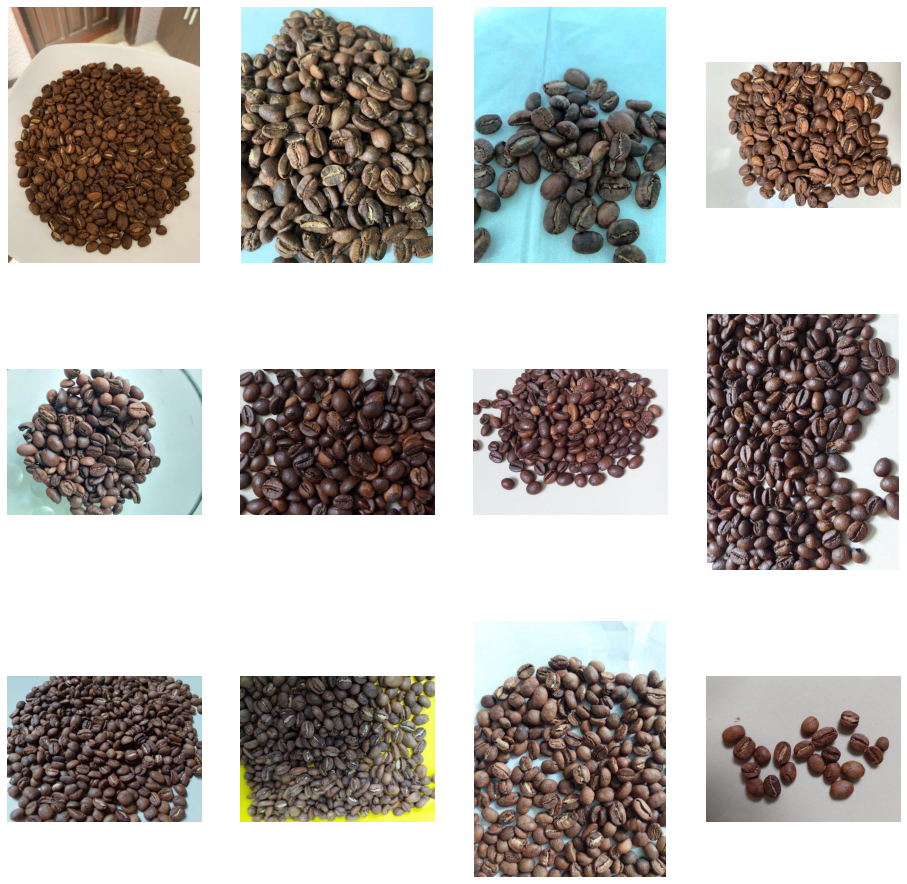

In [ ]:
%matplotlib inline

# Parameters for our graph; we'll output images in a 3x4 configuration
nrows = 3
ncols = 4

pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(16, 16)

pic_index+=20

acehgayo = [os.path.join(train_acehgayo_dir, fname) 
                for fname in train_acehgayo_fnames[ pic_index-4:pic_index] 
               ]

dampit = [os.path.join(train_dampit_dir, fname) 
                for fname in train_dampit_fnames[ pic_index-4:pic_index]
               ]

toraja = [os.path.join(train_toraja_dir, fname) 
                for fname in train_toraja_fnames[ pic_index-4:pic_index]
               ]

for i, img_path in enumerate(acehgayo+dampit+toraja):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# Using Transfer Learning Model

In [ ]:
# Using transfer learning
handle_base, pixels, FV_SIZE = ("efficientnet", 224, 1280)
MODULE_HANDLE ="https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2".format(handle_base)

IMAGE_SIZE = (pixels, pixels)

print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2 with input size (224, 224) and output dimension 1280


# Making ImageGenerator

In [ ]:
# Set the batch size
BATCH_SIZE = 64

In [ ]:
# Datagen
train_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(
    # rescale=1./255,
    # rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen =  ImageDataGenerator()
test_datagen =  ImageDataGenerator()

# Flow training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical'
)

# Flow validation data generator
validation_generator = valid_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)

# Flow test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)

Found 1200 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [ ]:
class_names = list(train_generator.class_indices.keys())

# Create a labels.txt file with the class names

with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

# Building Model

In [ ]:
feature_extractor = hub.KerasLayer(
    MODULE_HANDLE,
    input_shape=IMAGE_SIZE + (3,), 
    output_shape=[FV_SIZE],
    trainable=False
)

In [ ]:
# Building model with transfer learning
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Building model with https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              3413024   
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 3,495,203
Trainable params: 82,179
Non-trainable params: 3,413,024
_________________________________________________________________


In [ ]:
# Compiling model with optimizer & loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model Training Using EfficientNet-Lite

In [ ]:
# Using callbacks
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", 
    mode="min",
    patience=3,
    restore_best_weights=True
)

In [ ]:
# Training model
EPOCHS = 25

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/25
19/19 [==============================] - 35s 940ms/step - loss: 0.9949 - accuracy: 0.4933 - val_loss: 0.8117 - val_accuracy: 0.6467
Epoch 2/25
19/19 [==============================] - 17s 918ms/step - loss: 0.7650 - accuracy: 0.6667 - val_loss: 0.7074 - val_accuracy: 0.6733
Epoch 3/25
19/19 [==============================] - 17s 883ms/step - loss: 0.6896 - accuracy: 0.6942 - val_loss: 0.6670 - val_accuracy: 0.6733
Epoch 4/25
19/19 [==============================] - 19s 1s/step - loss: 0.6094 - accuracy: 0.7450 - val_loss: 0.6054 - val_accuracy: 0.7333
Epoch 5/25
19/19 [==============================] - 16s 861ms/step - loss: 0.5627 - accuracy: 0.7683 - val_loss: 0.6063 - val_accuracy: 0.7333
Epoch 6/25
19/19 [==============================] - 16s 859ms/step - loss: 0.5438 - accuracy: 0.7792 - val_loss: 0.5675 - val_accuracy: 0.7800
Epoch 7/25
19/19 [==============================] - 16s 865ms/step - loss: 0.5281 - accuracy: 0.7767 - val_loss: 0.5903 - val_accuracy: 0.7200
Ep

# Training Results

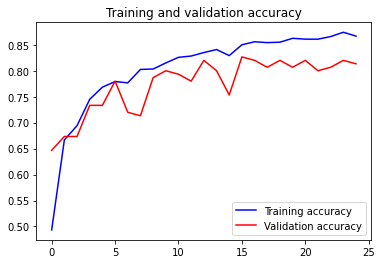

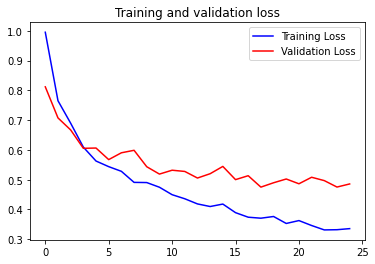

In [ ]:
# Visualize accuracy & loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate final score on Validation and Testing data
scores = model.evaluate(train_generator)
scores = model.evaluate(validation_generator)
scores = model.evaluate(test_generator)

3/3 [==============================] - 1s 169ms/step - loss: 0.3974 - accuracy: 0.8200


In [ ]:
# Classification report
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_generator.classes, y_pred)

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=class_names))

Classification Report
              precision    recall  f1-score   support

    acehgayo       0.91      0.86      0.89        50
      dampit       0.87      0.68      0.76        50
      toraja       0.72      0.92      0.81        50

    accuracy                           0.82       150
   macro avg       0.84      0.82      0.82       150
weighted avg       0.84      0.82      0.82       150



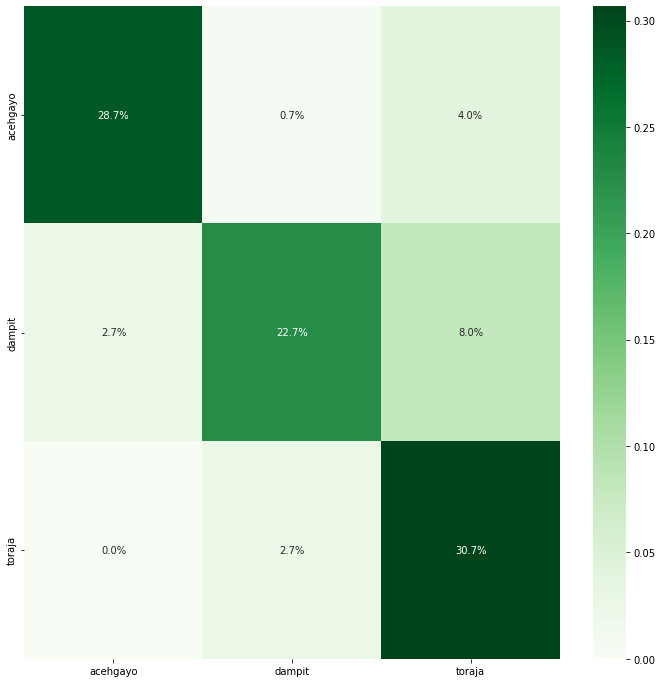

In [ ]:
# Confusion Matrix
plt.figure(figsize=(12,12))
ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap="Greens", xticklabels=class_names, yticklabels=class_names)

plt.show()

# Image Recognition

In [ ]:
# Uploading images for testing
uploaded = files.upload()

for fn in uploaded.keys():
 
  path = fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes)

Saving IMG_1261.JPG to IMG_1261.JPG
[[0.44627485 0.5184803  0.03524491]]


In [ ]:
np.set_printoptions(threshold=np.inf)
{
  "instances" : [
    images
  ]
}

{'instances': [array([[[[ 63.,  31.,  18.],
           [ 48.,  26.,  15.],
           [ 26.,  19.,   9.],
           [ 23.,  19.,  10.],
           [ 38.,  27.,  21.],
           [ 48.,  28.,  21.],
           [ 93.,  56.,  40.],
           [199., 152., 124.],
           [226., 176., 143.],
           [217., 168., 125.],
           [213., 160., 110.],
           [200., 147., 105.],
           [178., 127.,  98.],
           [174., 124., 101.],
           [141.,  93.,  81.],
           [130.,  86.,  77.],
           [ 99.,  59.,  51.],
           [138., 102.,  90.],
           [165., 132., 117.],
           [137., 106.,  86.],
           [140., 109.,  81.],
           [116.,  82.,  57.],
           [ 95.,  57.,  38.],
           [156., 114.,  98.],
           [239., 196., 180.],
           [254., 208., 193.],
           [251., 205., 190.],
           [231., 184., 166.],
           [211., 164., 144.],
           [191., 145., 122.],
           [175., 124., 103.],
           [149., 102.,  8

# Exporting Model

In [ ]:
# Saving model
model.save('model_v4.h5')
model.save('model_v4')
!zip -r 'model_v4.zip' 'model_v4'

INFO:tensorflow:Assets written to: model_v4/assets


INFO:tensorflow:Assets written to: model_v4/assets


  adding: model_v4/ (stored 0%)
  adding: model_v4/assets/ (stored 0%)
  adding: model_v4/keras_metadata.pb (deflated 85%)
  adding: model_v4/saved_model.pb (deflated 90%)
  adding: model_v4/variables/ (stored 0%)
  adding: model_v4/variables/variables.index (deflated 79%)
  adding: model_v4/variables/variables.data-00000-of-00001 (deflated 8%)


In [ ]:
# Saving model to tflite
converter = tf.lite.TFLiteConverter.from_saved_model('model_v4')

# Set the optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

# Invoke the converter to generate the TFLite model
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('./model_v4.tflite')
tflite_model_file.write_bytes(tflite_model)``

3962256